# Items Recommendation with K-Means Clustering.


lk

This notebook explores the clustering capabilities of the SageMaker built-in K-Means algorithm. The objective is to make item recommendations to users based on their similarities.

In this case, we will use the MovieLens dataset as training data. It will be stored on S3 as ".csv" files :
    - movies.csv
    - ratings.csv
    
The present code will inspect and visualize the data, prepare and transform the data, train a model, assign labels to users based on their closest cluster and finally generate the top 20 movie recommendations based on their preferences.

Let's import all useful librairies.

In [2]:
import pandas as pd
import numpy as np
import io
import sagemaker.amazon.common as smac
from pandas import DataFrame

import boto3
from sagemaker import get_execution_role
import sagemaker
from sagemaker import KMeans
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

Let's get the appropriate credentials for SageMaker to our access S3 bucket 
and load the csv files into our notebook.

In [3]:
role = get_execution_role()
bucket='guruchallenge-bucket'
sub_folder = 'movielens_dataset'

In [4]:
data_key = 'movies.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)
movies = pd.read_csv(data_location, low_memory=False, delimiter=',', encoding='utf-8')
movies_save = movies
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [5]:
data_key = 'ratings.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)
ratings = pd.read_csv(data_location, low_memory=False, delimiter=',', encoding='utf-8')
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
ratingsCount = len(ratings)
moviesCount = len(movies)
usersCount = len(ratings['userId'].value_counts())
print('This dataset contains', ratingsCount, 'ratings of', moviesCount, 'movies by', usersCount, 'users.')

This dataset contains 100836 ratings of 9742 movies by 610 users.


Let's drop the timestamp field: the temporal dimension is not relevant for our clustering strategy.
Let's also count the number of ratings for each user: 'UserRatingCount'.

In [7]:
ratings = ratings.drop(['timestamp'], axis=1)
ratings['UserRatingCount'] = ratings.groupby('userId')['userId'].transform('count')
ratings

,userId,movieId,rating,UserRatingCount
0,1,1,4.0,232
1,1,3,4.0,232
2,1,6,4.0,232
3,1,47,5.0,232
4,1,50,5.0,232
...,...,...,...,...
100831,610,166534,4.0,1302
100832,610,168248,5.0,1302
100833,610,168250,5.0,1302
100834,610,168252,5.0,1302


Let's split the 'genres' field into separate categories. Let's one-hot-encode them and drop the initial 'genres' and 'title' fields.

In [8]:
movies['genres'] = movies.genres.str.split('|')

In [9]:
df = movies
x = []
for index, row in movies.iterrows():
    x.append(index)
    for genre in row['genres']:
        df.at[index, genre] = 1

In [10]:
movies = movies.fillna(0)
movies = movies.drop(['genres','title'], axis=1)
movies

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9738,193583,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9739,193585,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9740,193587,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's create a Pandas Dataframe by merging 'ratings' and 'movies' with matching movieId values.

In [11]:
df = pd.merge(ratings, movies, on='movieId')
df = df.sort_values('userId')
df

,userId,movieId,rating,UserRatingCount,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,4.0,232,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12117,1,2389,2.0,232,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12126,1,2395,5.0,232,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12182,1,2406,4.0,232,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,1,70,3.0,232,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,1302,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26937,610,589,5.0,1302,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69808,610,66097,4.0,1302,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69820,610,71464,4.0,1302,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's visualize the number of ratings per user with Matplotlib.

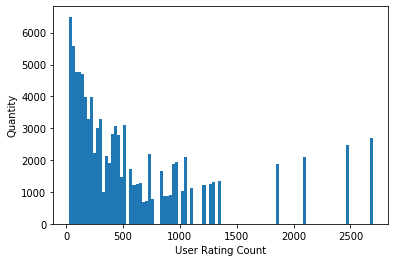

In [12]:
x = df['UserRatingCount']
n_bins = 100
plt.hist(x, bins=n_bins)
plt.xlabel('User Rating Count')
plt.ylabel('Quantity')
plt.show()

There seems to be 4 outliers that each ranked more than 1500 movies. Let's list their ID and number of ratings.

In [13]:
df[df['UserRatingCount'] >= 1500]['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
Name: userId, dtype: int64

These 4 combined users rated a total of 9148 movies. This is nearly 10% of all ratings for just 4 users. As this will significantly affect our clustering process, let's get rid of these outliers. Also, as we will use MinMaxScaling later on, outliers should be removed. 

In [14]:
df.drop(df[df['UserRatingCount'] >= 1500].index, inplace = True)

Our data is now more compact.

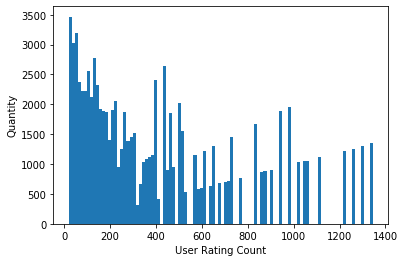

In [15]:
x = df['UserRatingCount']
n_bins = 100
plt.hist(x, bins=n_bins)
plt.xlabel('User Rating Count')
plt.ylabel('Quantity')
plt.show()

The one-hot-encoding of genres generated a set of vectors for all movies seen by a given user. Now for each user, let's multiply each vector by its matching rating. By summing all columns for a given user, it creates a "scoring vector" that represents their tastes, based on their viewing history. Let's divide the scoring vectors by their matching UserRatingCount to generate the mean scoring for each user.

In [16]:
df.loc[:,['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']] = df.loc[:,['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']].multiply(df.loc[:, 'rating'], axis="index")
df

,userId,movieId,rating,UserRatingCount,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,4.0,232,4.0,4.0,4.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12117,1,2389,2.0,232,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12126,1,2395,5.0,232,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12182,1,2406,4.0,232,4.0,0.0,0.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,1,70,3.0,232,0.0,0.0,0.0,3.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,1302,0.0,0.0,0.0,5.0,0.0,0.0,...,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26937,610,589,5.0,1302,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69808,610,66097,4.0,1302,0.0,4.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69820,610,71464,4.0,1302,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df.loc[:,['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']] = df.loc[:,['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']].divide(df.loc[:, 'UserRatingCount'], axis="index")
df

,userId,movieId,rating,UserRatingCount,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,4.0,232,0.017241,0.017241,0.017241,0.017241,0.017241,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12117,1,2389,2.0,232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008621,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12126,1,2395,5.0,232,0.000000,0.000000,0.000000,0.021552,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12182,1,2406,4.0,232,0.017241,0.000000,0.000000,0.017241,0.000000,0.017241,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,1,70,3.0,232,0.000000,0.000000,0.000000,0.012931,0.000000,0.000000,...,0.012931,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,1302,0.000000,0.000000,0.000000,0.003840,0.000000,0.000000,...,0.003840,0.0,0.00384,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26937,610,589,5.0,1302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.00384,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69808,610,66097,4.0,1302,0.000000,0.003072,0.000000,0.000000,0.003072,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69820,610,71464,4.0,1302,0.000000,0.000000,0.000000,0.003072,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df = df.groupby(['userId'], as_index=False)['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)'].sum()
df

,userId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1.607759,0.586207,0.823276,1.530172,0.870690,0.482759,1.327586,1.676724,0.844828,...,0.254310,0.323276,0.728448,0.426724,0.443966,0.000000,0.000000,0.129310,0.021552,0.0
1,2,0.431034,0.000000,0.000000,0.965517,0.000000,0.155172,2.275862,1.500000,1.310345,...,0.103448,0.275862,0.534483,0.155172,0.000000,0.448276,0.517241,0.120690,0.000000,0.0
2,3,0.769231,0.051282,0.064103,0.230769,0.346154,0.064103,0.307692,1.282051,0.025641,...,0.961538,0.128205,1.615385,0.064103,0.012821,0.000000,0.000000,0.000000,0.000000,0.0
3,4,0.490741,0.111111,0.175926,1.689815,0.324074,0.907407,1.935185,0.384259,0.476852,...,0.078704,0.370370,0.157407,0.115741,0.296296,0.037037,0.013889,0.175926,0.074074,0.0
4,5,0.590909,0.590909,0.840909,1.181818,0.659091,0.772727,2.159091,0.636364,1.045455,...,0.068182,0.090909,0.113636,0.227273,0.500000,0.000000,0.250000,0.136364,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,606,0.461883,0.139910,0.151570,1.346188,0.313004,1.191031,2.371300,0.430493,0.435874,...,0.156054,0.309417,0.252018,0.221076,0.147085,0.017040,0.043946,0.052018,0.027354,0.0
602,607,0.834225,0.106952,0.347594,0.978610,0.401070,0.545455,1.759358,1.433155,0.550802,...,0.770053,0.422460,0.625668,0.133690,0.096257,0.000000,0.026738,0.042781,0.000000,0.0
603,608,0.701564,0.206378,0.260529,1.169073,0.400722,0.368231,1.158243,1.110108,0.634777,...,0.387485,0.294826,0.662455,0.081829,0.109507,0.021661,0.057762,0.034898,0.018051,0.0
604,609,0.864865,0.081081,0.162162,0.621622,0.081081,0.432432,1.729730,0.918919,0.567568,...,0.189189,0.000000,0.405405,0.378378,0.000000,0.162162,0.081081,0.108108,0.000000,0.0


As some outliers were removed from our dataset, let's map IDs and indexes properly and finally drop the 'userId' field.

In [19]:
userId_mapping = pd.DataFrame(df, columns = ['userId'])

In [20]:
df = df.drop(['userId'], axis=1)

Features are gaussian shaped. Here are a few examples:

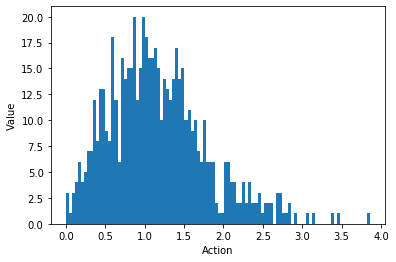

In [21]:
n_bins = 100
plt.hist(df['Action'], bins=n_bins)
plt.xlabel('Action')
plt.ylabel('Value')
plt.show()

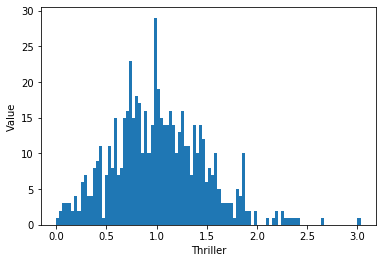

In [22]:
n_bins = 100
plt.hist(df['Thriller'], bins=n_bins)
plt.xlabel('Thriller')
plt.ylabel('Value')
plt.show()

Let's visualize the heatmap of our dataframe's current state:

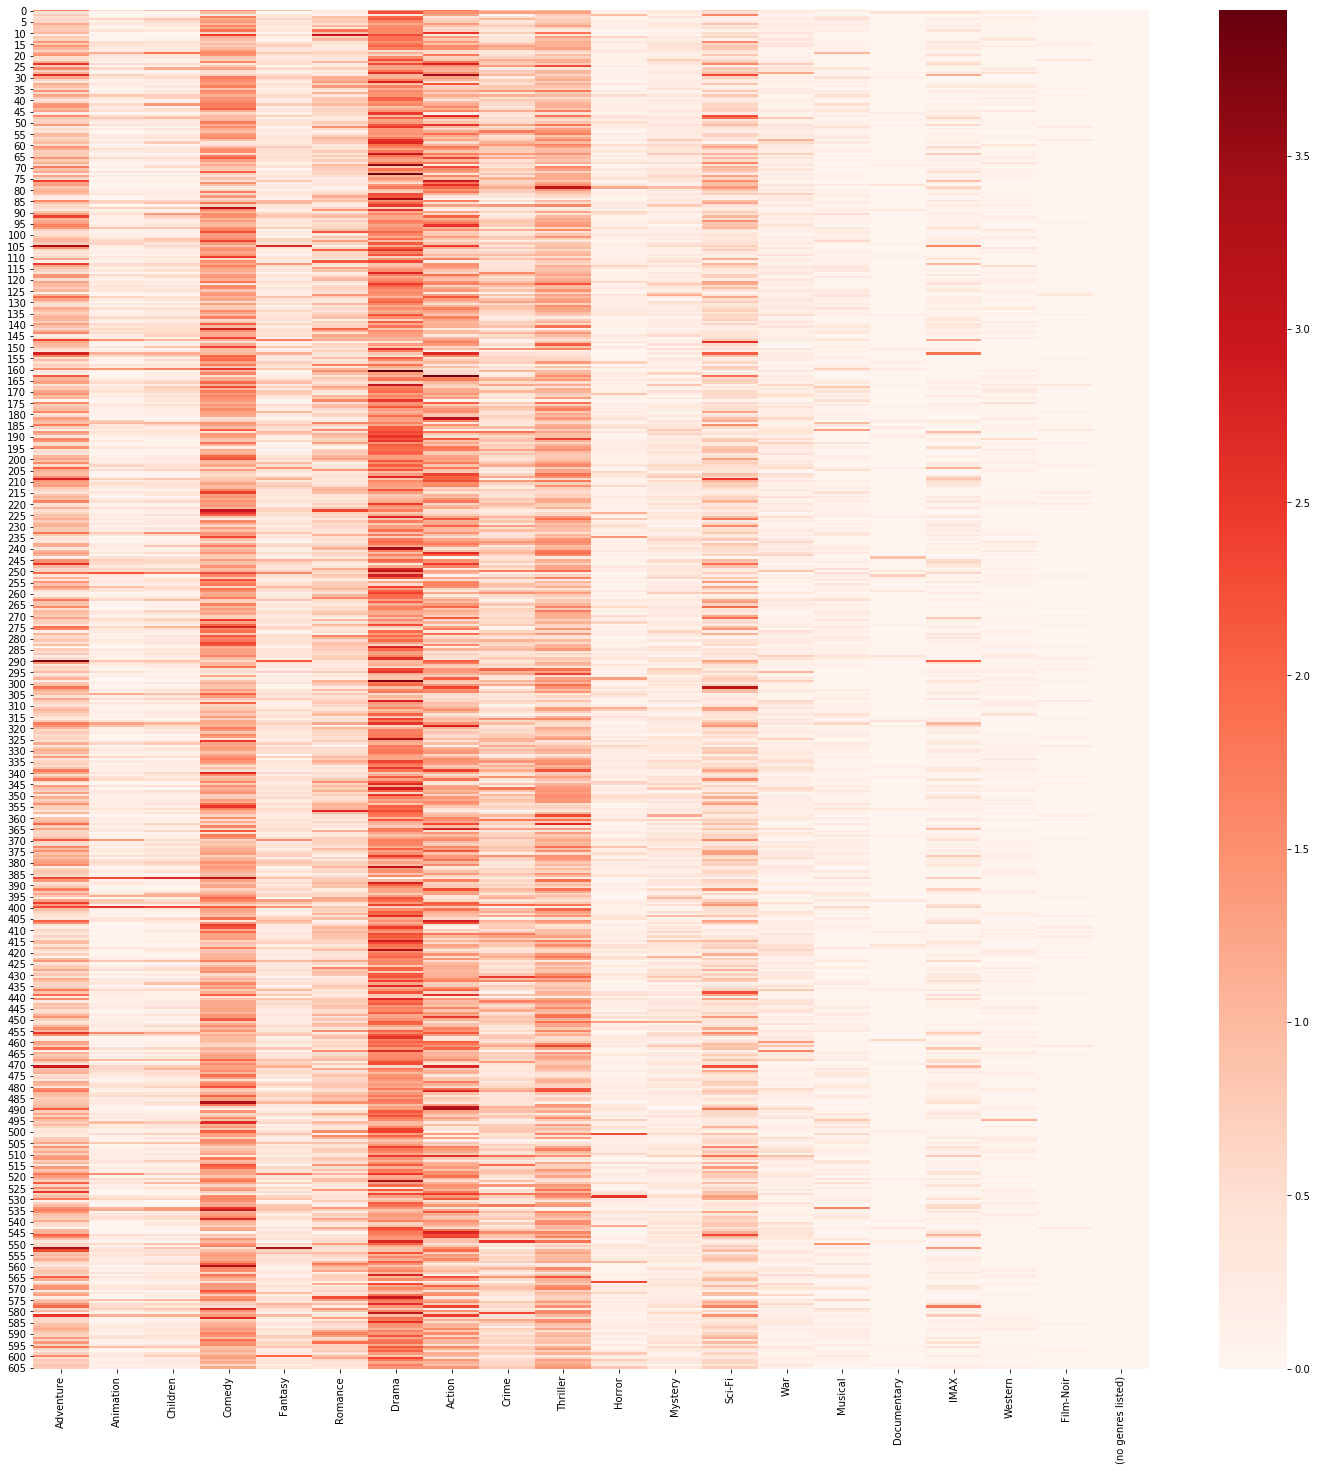

In [24]:
fig, ax1 = plt.subplots(figsize = (25, 25))
sns.heatmap(df, ax = ax1, cmap = 'Reds')

Movies with most views contain drama or comedy, as they are usually the most popular genres among users. Even for users who rate these genres lower, these features will inevitably gain more importance in the dataset and will affect clustering. Inversely, less frequent genres like documentary or film-noir tend to disappear from the heatmap, making clustering nearly impossible with these genres.

To address this issue, we need a more relevant and balanced clustering approach. Let's perform feature scaling for better user segmentation: MinMaxScaler will scale all features from 0 to 1, therefore it will emphasize users who have a stronger preference than others on any genre. 

Users with common interests will be clustered together and will receive mainstream recommendations. Users with more specific preferences will be clustered accordingly and will receive appropriate movie suggestions based on what similar users (from the same cluster) rated highly.

In [27]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled.columns = df.columns
df_scaled.index = df.index

In [28]:
df_scaled.describe()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
count,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,0.257251,0.102748,0.125062,0.379740,0.129136,0.227371,0.408242,0.301290,0.267316,0.337266,0.084826,0.244076,0.204029,0.137253,0.089821,0.036399,0.086304,0.068486,0.075043,0.007238
std,0.145536,0.114285,0.117371,0.158170,0.098418,0.131171,0.155554,0.161113,0.152049,0.151906,0.098939,0.158748,0.140064,0.116509,0.108434,0.093155,0.120265,0.087628,0.153071,0.057170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.159562,0.031386,0.046076,0.273267,0.069709,0.135203,0.301416,0.187546,0.167807,0.238356,0.033891,0.134186,0.106747,0.066804,0.013984,0.000000,0.000509,0.000000,0.000000,0.000000
50%,0.235969,0.072692,0.097281,0.362897,0.114286,0.203704,0.395450,0.282176,0.246758,0.328356,0.062512,0.228128,0.179335,0.111241,0.060389,0.000000,0.049005,0.043965,0.000000,0.000000
75%,0.327878,0.141171,0.175426,0.458843,0.163504,0.286311,0.512064,0.388489,0.337640,0.434180,0.103456,0.319070,0.263218,0.183693,0.124407,0.031379,0.113347,0.101260,0.087596,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's have a look at the newly generated heatmap which shows a much wider representation of genres.

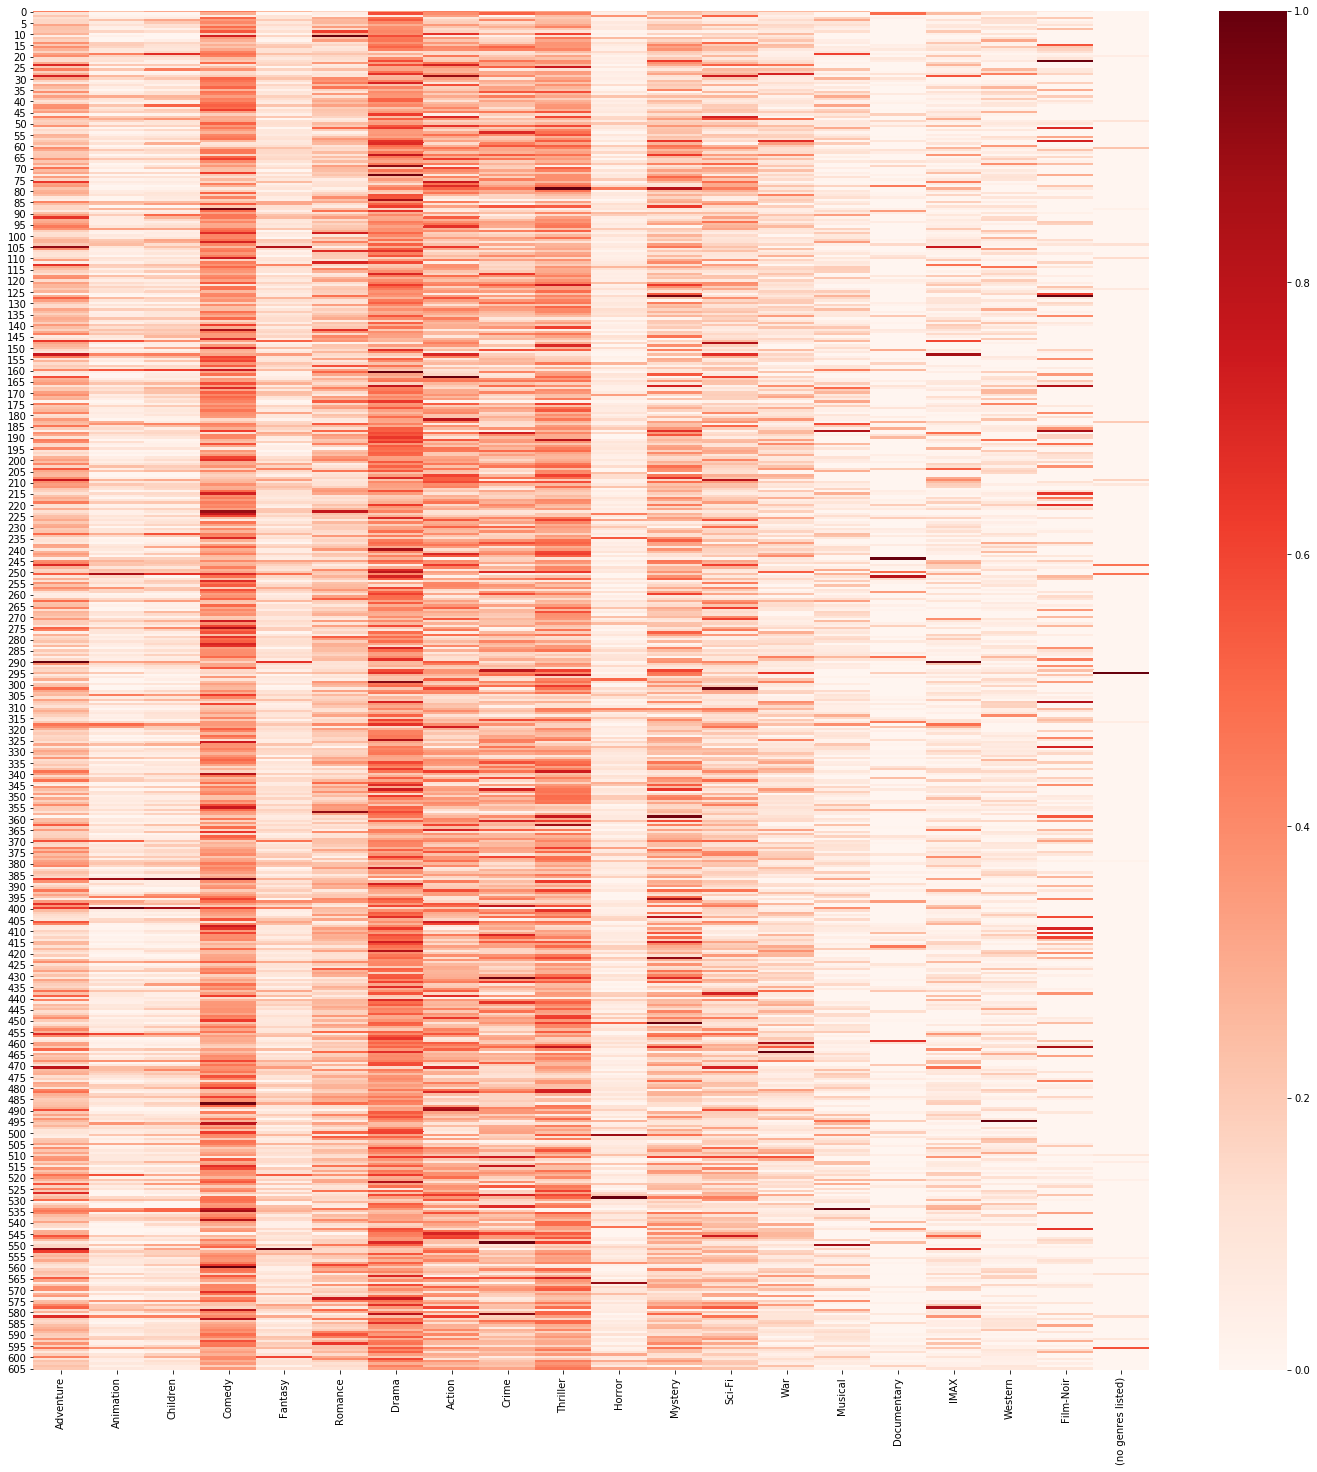

In [29]:
fig, ax1 = plt.subplots(figsize = (25, 25))
sns.heatmap(df_scaled, ax = ax1, cmap = 'Reds')

The built-in K-Means algorithm expects float32 as input format. The 'df_scaled' dataframe is converted to float32 and used as training dataset. The model artifacts are stored onto S3. Training will be performed on a single c4.xlarge. We are choosing K = 10 clusters for this training.

In [37]:
data_train = df_scaled
data_train = data_train.astype('float32')
num_clusters = 10
output_location = 's3://' + bucket + '/model-artifacts'

kmeans = KMeans(role=role,
               train_instance_count=1,
               train_instance_type='ml.c4.xlarge',
               output_path=output_location,
               k=num_clusters)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Now visualizing our training data: 606 users on 20 features in float32 format.

In [38]:
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606 entries, 0 to 605
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Adventure           606 non-null    float32
 1   Animation           606 non-null    float32
 2   Children            606 non-null    float32
 3   Comedy              606 non-null    float32
 4   Fantasy             606 non-null    float32
 5   Romance             606 non-null    float32
 6   Drama               606 non-null    float32
 7   Action              606 non-null    float32
 8   Crime               606 non-null    float32
 9   Thriller            606 non-null    float32
 10  Horror              606 non-null    float32
 11  Mystery             606 non-null    float32
 12  Sci-Fi              606 non-null    float32
 13  War                 606 non-null    float32
 14  Musical             606 non-null    float32
 15  Documentary         606 non-null    float32
 16  IMAX    

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,0.433396,0.226919,0.310065,0.460224,0.265353,0.160920,0.332711,0.434259,0.336310,0.324029,0.099116,0.271914,0.233280,0.260776,0.269291,0.000000,0.000000,0.114471,0.059267,0.0
1,0.116192,0.000000,0.000000,0.290395,0.000000,0.051724,0.576699,0.388489,0.521624,0.420669,0.040318,0.232034,0.171164,0.094828,0.000000,0.495463,0.246684,0.106840,0.000000,0.0
2,0.207358,0.019851,0.024143,0.069408,0.105495,0.021368,0.070296,0.332042,0.010207,0.245172,0.374753,0.107836,0.517313,0.039174,0.007776,0.000000,0.000000,0.000000,0.000000,0.0
3,0.132287,0.043011,0.066258,0.508239,0.098765,0.302469,0.489044,0.099520,0.189826,0.206071,0.030674,0.311526,0.050408,0.070730,0.179721,0.040936,0.006624,0.155738,0.203704,0.0
4,0.159289,0.228739,0.316706,0.355451,0.200866,0.257576,0.546654,0.164814,0.416176,0.239792,0.026573,0.076466,0.036391,0.138889,0.303279,0.000000,0.119231,0.120715,0.000000,0.0
5,0.157103,0.070269,0.203904,0.409962,0.089293,0.268577,0.405752,0.190533,0.145794,0.253061,0.076956,0.150009,0.074451,0.083687,0.096586,0.000000,0.021264,0.118409,0.043790,0.0
6,0.317449,0.120968,0.118934,0.306702,0.141353,0.174342,0.293282,0.355263,0.225230,0.319952,0.051282,0.246249,0.279158,0.158808,0.131687,0.000000,0.084717,0.008736,0.117599,0.0
7,0.223682,0.041181,0.136225,0.492745,0.084296,0.347518,0.385284,0.220419,0.296444,0.420911,0.074632,0.214754,0.088577,0.143026,0.064527,0.000000,0.091326,0.113010,0.000000,0.0
8,0.222684,0.033661,0.032750,0.359612,0.066253,0.137681,0.393852,0.140757,0.190387,0.200695,0.076254,0.219423,0.167083,0.092995,0.039558,0.000000,0.031104,0.076978,0.239130,0.0
9,0.213727,0.160369,0.135853,0.554269,0.127347,0.619048,0.408315,0.168345,0.115159,0.094204,0.009744,0.039052,0.022874,0.065476,0.129977,0.000000,0.206099,0.000000,0.000000,0.0


In [39]:
job_name = 'kmeans-recom-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

Here is the job name kmeans-recom-job-20201120113720


Calling fit on the K-Means estimator to train our model. This process usually takes 3 to 5 minutes.

In [40]:
%%time
kmeans.fit(kmeans.record_set(data_train.values), job_name=job_name)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-20 11:37:24 Starting - Starting the training job...
2020-11-20 11:37:27 Starting - Launching requested ML instances......
2020-11-20 11:38:40 Starting - Preparing the instances for training.........
2020-11-20 11:40:09 Downloading - Downloading input data
2020-11-20 11:40:09 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/20/2020 11:40:32 INFO 140165052426048] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'e

Deploying our model on an endpoint. This step usually takes up to 10 minutes.

In [41]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!

Making inferences for the entire dataset: all users get a label from the closest cluster.

In [42]:
%%time 
result = kmeans_predictor.predict(data_train.values[0:len(data_train)])
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 51.3 ms, sys: 82 µs, total: 51.4 ms
Wall time: 297 ms


Now deleting the endpoint, as this incurs addtional costs.

In [43]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


That's it! All users are labeled.

In [128]:
userId_mapping['Cluster Labels'] = cluster_labels

Let's choose the cluster number that we want to visualize.

In [185]:
clusterNumber = 8

We are going to generate the top 20 movie recommendations for this cluster of users. First of all, let's identify all users IDs within our cluster.

In [186]:
users_cluster = [i for i, j in enumerate(cluster_labels) if j == clusterNumber]
users_cluster = userId_mapping['userId'].iloc[users_cluster]

Let's define 'clust_movieRatings' as the dataframe that contains all ratings for all movies viewed by users within this cluster. We are going to make movie recommendations from the data that this dataframe contains. 

In [187]:
clust_movieRatings = ratings.loc[ratings['userId'].isin(users_cluster)]
clust_movieRatings

,userId,movieId,rating,UserRatingCount
1569,16,47,3.5,98
1570,16,50,4.0,98
1571,16,111,4.5,98
1572,16,204,2.0,98
1573,16,260,3.0,98
...,...,...,...,...
84728,547,2859,3.0,21
84729,547,2917,4.0,21
84730,547,2919,3.0,21
84731,547,3039,4.0,21


Now let's visualize the cluster's heatmap which will better reflect specific preferences from this cluster of users. 

In [188]:
clust_df_scaled = df_scaled.iloc[users_cluster.index, :]

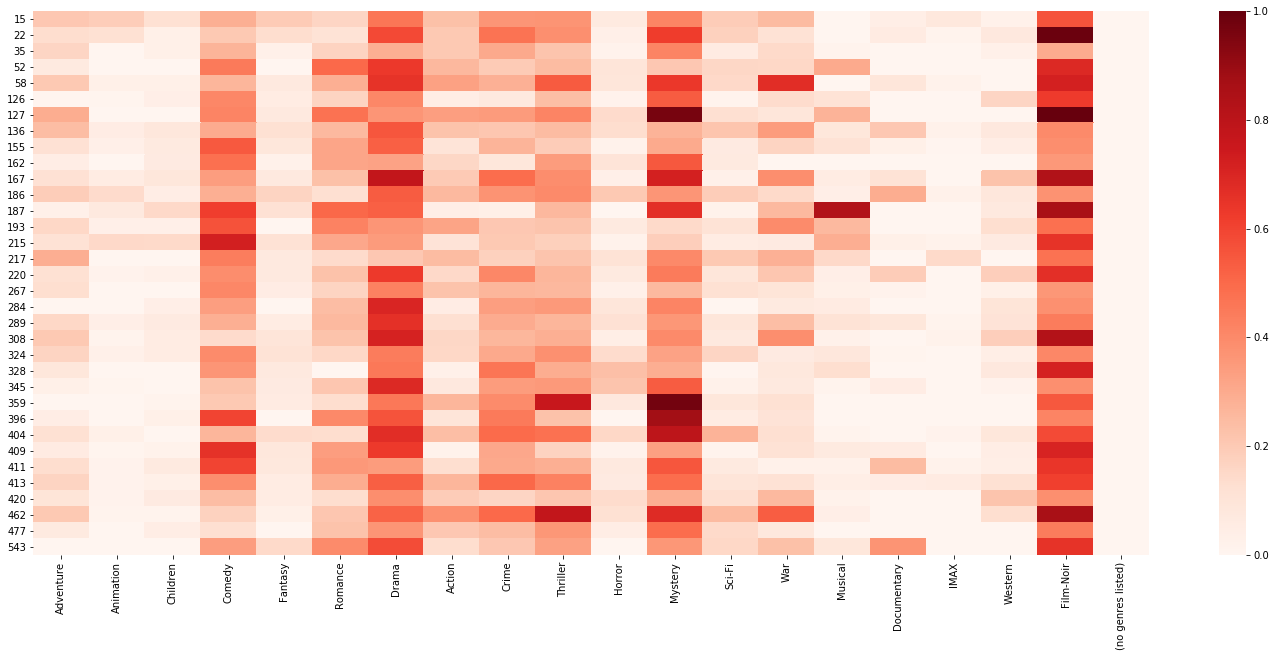

In [189]:
fig, ax1 = plt.subplots(figsize = (25, 10))
sns.heatmap(clust_df_scaled, ax = ax1, cmap = 'Reds')

Let's define the cluster mean rating for each movie (within the cluster), and let's merge this data to our 'clust_movieRatings' dataframe.

In [190]:
clust_meanRatings = pd.pivot_table(clust_movieRatings, index='userId', columns= 'movieId', values='rating')
clust_meanRatings = clust_meanRatings.mean(axis = 0, skipna = True)
clust_meanRatings_df = pd.DataFrame({'movieId':clust_meanRatings.index, 'clusterRating':clust_meanRatings.values})

clust_movieRatings = pd.merge(clust_movieRatings, clust_meanRatings_df, on='movieId')
clust_movieRatings = clust_movieRatings.drop(['userId', 'rating', 'UserRatingCount'], axis=1)

Let's add the 'ClustMovieRatingCount' variable to define how many times a movie was rated withing the cluster.

In [191]:
clust_movieRatings['ClustMovieRatingCount'] = clust_movieRatings.groupby('movieId')['movieId'].transform('count')

Let's finalize our 'clust_movieRatings' dataframe with all relevant data: a unique 'movieId' with its cluster rating, the number of times it was rated within the cluster, and the overall mean rating for each movie.

In [192]:
clust_movieRatings = clust_movieRatings.drop_duplicates('movieId')
clust_movieRatings.drop(clust_movieRatings[clust_movieRatings['ClustMovieRatingCount'] < bayesianThreshold].index, inplace = True)

user_movie_ratings = pd.pivot_table(ratings, index='userId', columns= 'movieId', values='rating')
movie_mean_ratings = user_movie_ratings.mean(axis = 0, skipna = True)
mean_ratings_df = pd.DataFrame({'movieId':movie_mean_ratings.index, 'MovieMeanRating':movie_mean_ratings.values})

clust_movieRatings = pd.merge(clust_movieRatings, mean_ratings_df, on='movieId')
clust_movieRatings

,movieId,clusterRating,ClustMovieRatingCount,MovieMeanRating
0,47,3.500000,7,3.975369
1,50,4.090909,11,4.237745
2,111,4.566667,15,4.105769
3,260,3.818182,11,4.231076
4,293,3.800000,5,4.018797
...,...,...,...,...
412,971,4.666667,3,4.100000
413,1240,3.500000,3,3.896947
414,2278,3.666667,3,3.523256
415,3052,2.500000,3,3.645570


Sorting items with their rating alone would not lead to proper rankings, as the number of times each item was ranked is of major importance too. To address this matter, IMDb uses the bayesian weighted rating formula:

Weighted Rating (𝑊𝑅)=(𝑣/(𝑣+𝑚))𝑅+(𝑚/(𝑣+𝑚))𝐶

Where:

R = average for the movie (within the cluster)

v = number of votes for the movie (within the cluster)

m = minimum votes required to be listed ('bayesianThreshold')

C = the mean vote across the whole report ('bayesianConstant')

In this particuliar case, the minimum view count for an item to be ranked (bayesianThreshold) is set to 3.

Let's add a 'weightedRating' field to our 'clust_movieRatings' dataframe.

In [193]:
bayesianThreshold = 3
bayesianConstant = clust_movieRatings['clusterRating'].mean()
clust_movieRatings['weightedRating'] = (clust_movieRatings['ClustMovieRatingCount']/(clust_movieRatings['ClustMovieRatingCount']+bayesianThreshold))*clust_movieRatings['clusterRating']+(bayesianThreshold/(clust_movieRatings['ClustMovieRatingCount']+3))*bayesianConstant

The newly added weighted ratings allow more relevant top 20 rankings in our dataframe. We can also compare the effect of this weighted rating compared to a movie overall mean rating, and the cluster mean rating:

In [194]:
clust_movieRatings.sort_values(by=['weightedRating'], inplace=True, ascending=False)
clust_movieRatings = clust_movieRatings.head(20)
clust_movieRatings

,movieId,clusterRating,ClustMovieRatingCount,MovieMeanRating,weightedRating
93,1212,4.857143,7,4.229167,4.568900
205,898,4.777778,9,4.310345,4.557417
149,922,4.750000,10,4.333333,4.553000
101,1284,4.900000,5,4.142857,4.523626
34,1208,4.681818,11,4.219626,4.513500
14,750,4.583333,18,4.268041,4.485191
10,541,4.625000,12,4.100806,4.479267
128,908,4.625000,12,4.184211,4.479267
30,1199,4.666667,9,4.177966,4.474084
266,933,4.800000,5,4.217391,4.461126


Finally, let's recommend all top 20 matching titles:

In [195]:
for i in clust_movieRatings['movieId'].values:
    print(movies_save.loc[movies_save['movieId'] == i]['title'])

913    Third Man, The (1949)
Name: title, dtype: object
680    Philadelphia Story, The (1940)
Name: title, dtype: object
704    Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
Name: title, dtype: object
983    Big Sleep, The (1946)
Name: title, dtype: object
909    Apocalypse Now (1979)
Name: title, dtype: object
602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object
474    Blade Runner (1982)
Name: title, dtype: object
690    North by Northwest (1959)
Name: title, dtype: object
901    Brazil (1985)
Name: title, dtype: object
714    To Catch a Thief (1955)
Name: title, dtype: object
1407    All Quiet on the Western Front (1930)
Name: title, dtype: object
731    His Girl Friday (1940)
Name: title, dtype: object
694    Casablanca (1942)
Name: title, dtype: object
98    Taxi Driver (1976)
Name: title, dtype: object
695    Maltese Falcon, The (1941)
Name: title, dtype: object
4396    Trial, The (Procès, Le) (1962)
Name: title, dtype: object
1426    Man for All Se